<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/sensor3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
seed=24
batch_size= 3
n_classes=1
from tensorflow.keras.preprocessing.image import ImageDataGenerator




#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
def trainGenerator(train_img_path, train_mask_path):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',rescale=1/255.)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
   
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        color_mode = 'grayscale',
        target_size=(512,512),
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None ,
        color_mode = 'grayscale',
        target_size=(512,512),
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    return train_generator

In [3]:
train_img_path = "/gdrive/MyDrive/TESI/prova/data/train_images"
train_mask_path = "/gdrive/MyDrive/TESI/prova/data/train_masks"
train_img_gen = trainGenerator(train_img_path, train_mask_path)

val_img_path = "/gdrive/MyDrive/TESI/prova/data/val_images"
val_mask_path = "/gdrive/MyDrive/TESI/prova/data/val_masks"
val_img_gen = trainGenerator(val_img_path, val_mask_path)

Found 384 images belonging to 1 classes.
Found 384 images belonging to 1 classes.
Found 96 images belonging to 1 classes.
Found 96 images belonging to 1 classes.


In [4]:
x, y = train_img_gen.__next__()
import numpy as np

x_val,y_val= val_img_gen.__next__()

In [5]:
print(x_val.shape)
print(y_val.shape)



(3, 512, 512, 1)
(3, 512, 512, 1)


In [6]:
import os
import tensorflow as tf

In [7]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir('/gdrive/MyDrive/TESI/prova/data/train_images/images'))
num_val_images = len(os.listdir('/gdrive/MyDrive/TESI/prova/data/val_images/images'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]
input_shape = (3,IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(3, 512, 512, 1)


In [8]:
from tensorflow.keras.layers import Conv2D, TimeDistributed,Dropout,Input, Dense,\
    BatchNormalization, GRU, Layer, Flatten,MaxPooling2D, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras import models

In [9]:
time_steps = 3
img_height = 512
img_width = 512
channels = 1

In [10]:
num_train_imgs = len(os.listdir('/gdrive/MyDrive/TESI/prova/data/train_images/images'))
num_val_images = len(os.listdir('/gdrive/MyDrive/TESI/prova/data/val_images/images'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size




In [11]:
input_l = layers.Input(shape=(time_steps,img_height, img_width,channels))
x =  (layers.TimeDistributed(layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1) ))) (input_l)
conv2 = layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(conv2)
x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
conv5 = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(conv5)
x = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
conv8 = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
x=layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2,2)))(conv8)
x=layers.Bidirectional(layers.ConvLSTM2D(256,kernel_size=(3,3),padding='same',strides=(1,1),return_sequences=True))(x)
up1 = layers.TimeDistributed( layers.Conv2DTranspose( 512,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat1 = layers.concatenate([up1, conv8])
x = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (concat1)
x = layers.TimeDistributed( layers.Conv2D( 256, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
up2 = layers.TimeDistributed( layers.Conv2DTranspose( 256,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat2 = layers.concatenate([up2, conv5])
x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (concat2)
x = layers.TimeDistributed( layers.Conv2D( 128, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (x)
up3 = layers.TimeDistributed( layers.Conv2DTranspose( 128,kernel_size=(3,3),padding='same',strides=(2,2)))(x)
concat3 = layers.concatenate([up3, conv2])
x = layers.TimeDistributed( layers.Conv2D( 64, kernel_size=(3, 3),padding='same',strides=(1,1) ) ) (concat3)
x=layers.Bidirectional(layers.ConvLSTM2D(32,kernel_size=(3,3),padding='same',strides=(1,1),return_sequences=True))(x)
out = layers.Conv2D(1,  (1, 1), activation='sigmoid')(x)
out = tf.reshape(x, (-1, 1, 512,512, 64))
#out = layers.Conv2D(1,  (1, 1), activation='sigmoid')(out)



model = models.Model(inputs=input_l, outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 512, 512  0           []                               
                                , 1)]                                                             
                                                                                                  
 time_distributed (TimeDistribu  (None, 3, 512, 512,  640        ['input_1[0][0]']                
 ted)                            64)                                                              
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 3, 512, 512,  36928      ['time_distributed[0][0]']       
 buted)                          64)                                                          

In [ ]:
model = tf.keras.Model(inputs=[input_l], outputs=[out])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)


Epoch 1/10
128/128 [==============================] - 440s 3s/step - loss: 1.0895 - accuracy: 0.2379 - val_loss: 0.8760 - val_accuracy: 0.2457
Epoch 2/10
128/128 [==============================] - 208s 2s/step - loss: 0.8775 - accuracy: 0.2481 - val_loss: 0.8778 - val_accuracy: 0.2479
Epoch 3/10
128/128 [==============================] - 208s 2s/step - loss: 0.8775 - accuracy: 0.2473 - val_loss: 0.8749 - val_accuracy: 0.2463
Epoch 4/10
128/128 [==============================] - 208s 2s/step - loss: 0.8774 - accuracy: 0.2470 - val_loss: 0.8773 - val_accuracy: 0.2471
Epoch 5/10
128/128 [==============================] - 208s 2s/step - loss: 0.8774 - accuracy: 0.2474 - val_loss: 0.8765 - val_accuracy: 0.2480
Epoch 6/10
128/128 [==============================] - 208s 2s/step - loss: 0.8776 - accuracy: 0.2479 - val_loss: 0.8765 - val_accuracy: 0.2469
Epoch 7/10
128/128 [==============================] - 208s 2s/step - loss: 0.8775 - accuracy: 0.2478 - val_loss: 0.8767 - val_accuracy: 0.2472

In [80]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('sensor3D.h5', verbose=1, save_best_only=True)
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [19]:

model.save('/gdrive/MyDrive/TESI/sensor3D.hdf5')

In [20]:
from matplotlib import pyplot as plt

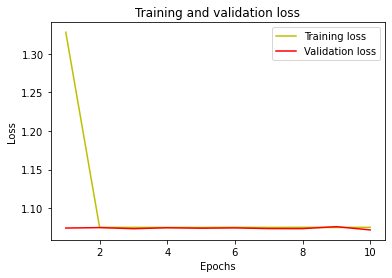

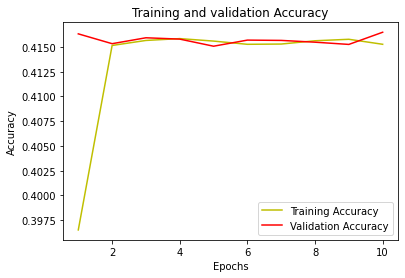

In [55]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [111]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K



smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

TypeError: ignored

In [112]:
from tensorflow.keras.metrics import Recall, Precision


metrics = [Precision(),Recall()]

In [115]:
model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=metrics)

In [116]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_gen,
          callbacks=callbacks,
          validation_steps=val_steps_per_epoch)

Epoch 1/10


ValueError: ignored

In [24]:
#Load previously saved model
from keras.models import load_model
model = load_model("/gdrive/MyDrive/TESI/sensor3D.hdf5", compile=False)

In [60]:
test_image_batch, test_mask_batch = val_img_gen.__next__()

In [29]:
test_mask_batch.shape

(3, 512, 512, 1)

In [32]:
y_pred=model.predict(test_image_batch)

ValueError: ignored

In [33]:
y_pred=model.predict(3,test_image_batch)
#y_pred_argmax=np.argmax(y_pred, axis=3)
#y_argmax = np.argmax(test_mask_batch, axis=3)

IndexError: ignored

In [ ]:
import random
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth=test_mask_batch[test_img_number]
ground_truth = np.argmax(ground_truth, axis=2)
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()